In [1]:
# First, we can import some functions so we can use the model
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
import matplotlib.pyplot as plt
from cobra.flux_analysis import production_envelope

In [2]:
# Second, we can read the GEM and save it as ‘model’
model = read_sbml_model('data/iML1515.xml')

In [3]:
# DIY PPP:

# ac_c <--ACKr--> actp_c <--PTAr--> accoa_c <--ACACT1r--> aacoa_c <--HACD1--> 3hbcoa_c --SK_3hbcoa_c--> p3HB

# Growth of E. coli with the heterologous pathway in a basal state (no Overexpression or KO's):
max_growth = model.optimize().objective_value

growth_basal_l = list()
p3HB_basal_l = list()
i = 1.0

while i > 0:

    # One way for dealing with production coupled to growth is to set biomass production boundaries so you force the model to at least produce a set amount of biomass when optimizing for a desired product.
    min_growth_total = i * max_growth  
    max_growth_total = 1.0 * max_growth   
    model.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M").bounds = min_growth_total, max_growth_total

    with model:
        r_p3HB = model.add_boundary(model.metabolites.get_by_id('3hbcoa_c'), type='sink')
        model.objective = r_p3HB
        solution_basal = model.optimize()
        p3HB_basal = solution_basal.objective_value
        growth_basal = solution_basal.fluxes["BIOMASS_Ec_iML1515_core_75p37M"]
    
    growth_basal_l.append(growth_basal)
    p3HB_basal_l.append(p3HB_basal)
    
    i -= 0.01

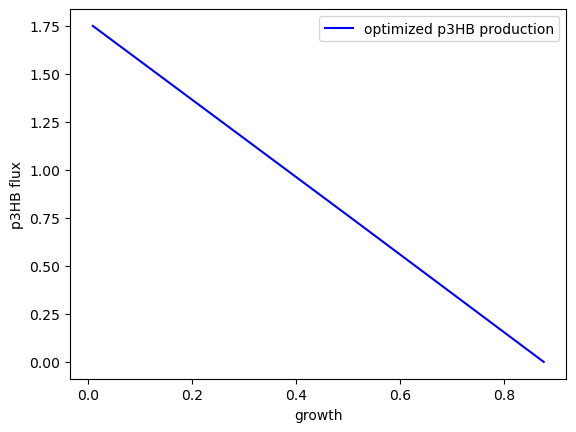

In [4]:
plt.plot(growth_basal_l, p3HB_basal_l, color='blue', linestyle='-', marker='', markersize=2, label='optimized p3HB production')

# Add labels and title
plt.xlabel('growth')
plt.ylabel('p3HB flux')

# Show the plot
plt.legend()
plt.show()

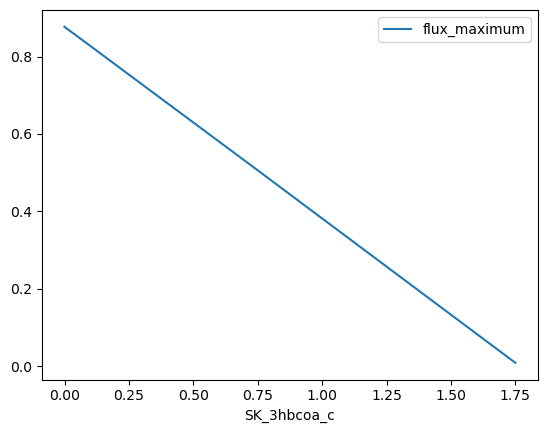

In [5]:
# PPP:
with model:
    r_p3HB = model.add_boundary(model.metabolites.get_by_id('3hbcoa_c'), type='sink')
    ppp_p3HB = production_envelope(model,
                        reactions=[model.reactions.get_by_id('SK_3hbcoa_c')],
                        objective=model.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M"))
    
pppp = ppp_p3HB.plot(x='SK_3hbcoa_c', y='flux_maximum')

# Overexpression strategies:

In [19]:
from cobra import Model, Reaction, Metabolite

# Load the iML1515_het.xml model
model = read_sbml_model("data/iML1515.xml")

# Display model information
print("Model Information:")
print(f"Number of reactions: {len(model.reactions)}")
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of genes: {len(model.genes)}")

Model Information:
Number of reactions: 2712
Number of metabolites: 1877
Number of genes: 1516


## Overexpression of phaB

In [7]:
with model:    
    # Find the 'phaB' reaction
    phaB_reaction = model.reactions.HACD1

    # Display initial flux of 'phaB' reaction
    model.optimize()
    print(f"\nInitial Flux of 'phaB' reaction: {phaB_reaction.flux}")
    phaB_initial = phaB_reaction.flux

    # Display initial growth rate
    print(f"Initial Growth Rate: {model.slim_optimize()}")
    growth_initial = model.slim_optimize()

    # Display initial production of '3hbcoa_c'
    hbcoa_production = model.metabolites.get_by_id('3hbcoa_c').summary(fva=0.95)
    print("\nInitial Production of '3hbcoa_c':")
    print(hbcoa_production)

    # Perform overexpression of 'phaB' reaction
    overexpression_factor = 10.0
    phaB_reaction.bounds = (0, phaB_reaction.upper_bound * overexpression_factor)

    # Display flux of 'phaB' reaction after overexpression
    print(f"\nFlux of 'phaB' reaction after overexpression: {phaB_reaction.flux}")
    phaB_final = phaB_reaction.flux

    # Display growth rate after overexpression
    print(f"Growth Rate after overexpression: {model.slim_optimize()}")
    growth_final = model.slim_optimize()

    # Display production of '3hbcoa_c' after overexpression
    hbcoa_production_after = model.metabolites.get_by_id('3hbcoa_c').summary(fva=0.95)
    print("\nProduction of '3hbcoa_c' after overexpression:")
    print(hbcoa_production_after)

growth_change = (growth_final - growth_initial) / growth_initial * 100
phaB_change = (phaB_final - phaB_initial) / phaB_initial * 100
print('Growth Change: ', growth_change)
print('phaB flux change: ', phaB_change)


Initial Flux of 'phaB' reaction: 0.31210576860983813
Initial Growth Rate: 0.8769972144269834

Initial Production of '3hbcoa_c':
3hbcoa_c
Formula: C25H38N7O18P3S

Producing Reactions
-------------------
Percent   Flux             Range Reaction                                  Definition
100.00% 0.3121 [-0.4533; 0.6917]    HACD1 aacoa_c + h_c + nadh_c <=> 3hbcoa_c + nad_c

Consuming Reactions
-------------------
Percent    Flux             Range Reaction                   Definition
100.00% -0.3121 [-0.6917; 0.4533]   ECOAH1 3hbcoa_c <=> b2coa_c + h2o_c

Flux of 'phaB' reaction after overexpression: 0.31210576867027073
Growth Rate after overexpression: 0.8769972144269859

Production of '3hbcoa_c' after overexpression:
3hbcoa_c
Formula: C25H38N7O18P3S

Producing Reactions
-------------------
Percent   Flux       Range Reaction                                  Definition
100.00% 0.3121 [0; 0.6917]    HACD1 aacoa_c + h_c + nadh_c --> 3hbcoa_c + nad_c

Consuming Reactions
-----------------

In [23]:
max_growth = model.optimize().objective_value
min_growth = 0.8 * max_growth  
max_growth = 1.0 * max_growth  
model.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M").bounds = min_growth, max_growth

with model:   
    # Find the 'phaC' reaction
    model.add_boundary(model.metabolites.get_by_id('3hbcoa_c'), type='demand')
    phaC_reaction = model.reactions.get_by_id('DM_3hbcoa_c')
    growth_reaction = model.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M")
    model.objective = phaC_reaction
    model.optimize()
    
    # Display initial flux of 'phaC' reaction
    print(f"\nInitial Flux of 'phaC' reaction: {phaC_reaction.flux}")

    # Display initial growth rate
    print(f"\nInitial Flux of 'growth' reaction: {growth_reaction.flux}")

    # Display initial production of '3hbcoa_c'
    hbcoa_production = model.metabolites.get_by_id('3hbcoa_c').summary(fva=0.95)
    print("\nInitial Production of '3hbcoa_c':")
    print(hbcoa_production)

    # Perform overexpression of 'phaC' reaction
    overexpression_factor = 2.0
    phaC_reaction.bounds = (phaC_reaction.lower_bound * overexpression_factor, phaC_reaction.upper_bound * overexpression_factor)

    # Display flux of 'phaC' reaction after overexpression
    print(f"\nFlux of 'phaC' reaction after overexpression: {phaC_reaction.flux}")

    # Display growth rate after overexpression
    print(f"Growth Rate after overexpression: {growth_reaction.flux}")

    # Display production of 'P3HB_c' after overexpression
    hbcoa_production_after = model.metabolites.get_by_id('3hbcoa_c').summary(fva=0.95)
    print("\nProduction of '3hbcoa_c' after overexpression:")
    print(hbcoa_production_after)



Initial Flux of 'phaC' reaction: 0.3545855513307894

Initial Flux of 'growth' reaction: 0.7015977715415799

Initial Production of '3hbcoa_c':
3hbcoa_c
Formula: C25H38N7O18P3S

Producing Reactions
-------------------
Percent   Flux            Range Reaction                                  Definition
100.00% 0.6043 [0.2869; 0.6656]    HACD1 aacoa_c + h_c + nadh_c <=> 3hbcoa_c + nad_c

Consuming Reactions
-------------------
Percent    Flux              Range    Reaction                   Definition
 58.68% -0.3546 [-0.3546; -0.3369] DM_3hbcoa_c                3hbcoa_c --> 
 41.32% -0.2497 [-0.3287; 0.04995]      ECOAH1 3hbcoa_c <=> b2coa_c + h2o_c

Flux of 'phaC' reaction after overexpression: 0.35458555133081415
Growth Rate after overexpression: 0.7015977715415799

Production of '3hbcoa_c' after overexpression:
3hbcoa_c
Formula: C25H38N7O18P3S

Producing Reactions
-------------------
Percent   Flux            Range Reaction                                  Definition
100.00% 0.6043 [0